<a href="https://colab.research.google.com/github/DmitryDudkin1987/variational-autoencoder-lego/blob/main/VAE_for_Lego.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)

from scipy.stats import norm
import pandas as pd



In [ ]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 24
NUM_FEATURES = 200
Z_DIM = 20
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

Found 24 images belonging to 6 classes.


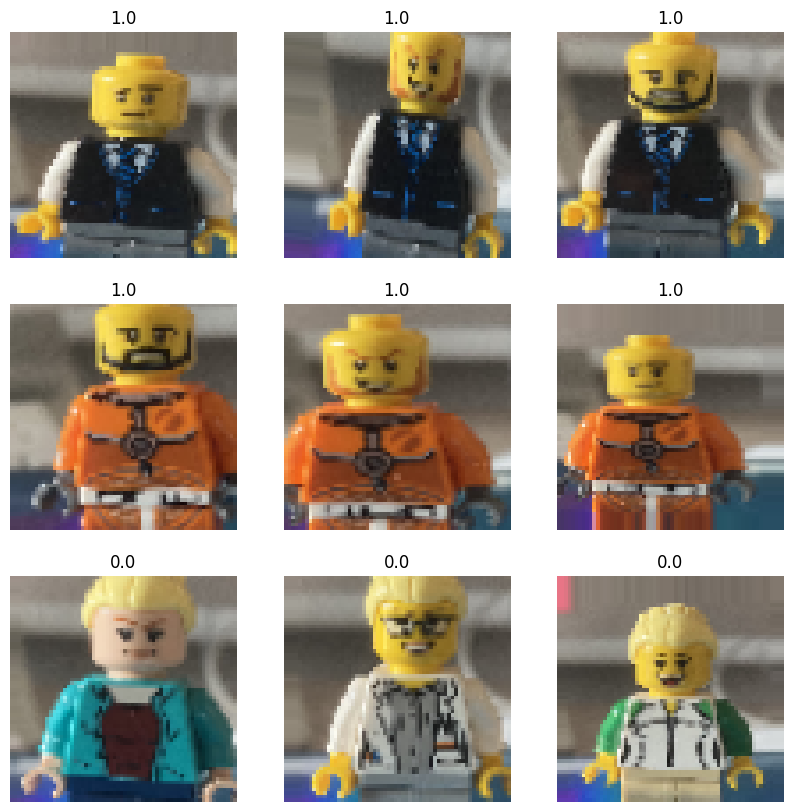

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Директория с изображениями
train_dir = '/content/drive/MyDrive/Colab Notebooks/Kaggle/lego_2'  # Укажите путь к вашей папке с изображениями

# Создание генератора данных с аугментацией
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #shear_range=0.1,
    zoom_range=0.2,
    #horizontal_flip=True,
    fill_mode='nearest'
)

# Создание потока данных
train_data_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    shuffle=False,
    class_mode='categorical',  # Замените на 'categorical' для многоклассовой классификации
    #save_to_dir="/content/Untitled Folder"
)

# Просмотр примеров
import matplotlib.pyplot as plt

# Получим один батч изображений и меток
images, lables = next(train_data_gen)

# Визуализируем первые 9 изображений из батча
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3,3 , i + 1)
    plt.imshow(images[i].astype("uint8"))  # Конвертируем обратно в uint8 для отображения
    plt.title (lables[i][0])
    plt.axis("off")
plt.show()


In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf


# Каталог для сохранения изображений
output_dir = "/content/train_data_lego"
os.makedirs(output_dir, exist_ok=True)


# Получаем список имён классов
class_labels = list(train_data_gen.class_indices.keys())

# Инициализация списков для хранения названий файлов и меток
file_names = []
labels = []

# Проходим по всем изображениям
for i in range(500):
    batch_images, batch_labels = next(train_data_gen)

    for j in range(batch_images.shape[0]):
        # Имя файла для сохранения
        img_file_name = f"{i * BATCH_SIZE + j}_label_{class_labels[np.argmax(batch_labels[j])]}.jpg"
        img_file_path = os.path.join(output_dir, img_file_name)

        # Сохраняем изображение
        tf.keras.preprocessing.image.save_img(img_file_path, batch_images[j])

        # Сохраняем имя файла и соответствующую метку
        file_names.append(img_file_name)
        labels.append(batch_labels[j])

# Преобразуем метки в массив NumPy
labels_array = np.array(labels)

# Создаем DataFrame с названиями файлов и метками
df = pd.DataFrame(labels_array, columns=class_labels)
df['file_name'] = file_names

# Переставляем колонку file_name в начало
df = df[['file_name'] + class_labels]

# Сохраним DataFrame в CSV файл (если нужно)
df.to_csv("file_labels.csv", index=False)

# Отображаем первые 5 строк таблицы
print(df.head())

          file_name  bald  blond  brown  fair  ginger  grey
0  0_label_bald.jpg   1.0    0.0    0.0   0.0     0.0   0.0
1  1_label_bald.jpg   1.0    0.0    0.0   0.0     0.0   0.0
2  2_label_bald.jpg   1.0    0.0    0.0   0.0     0.0   0.0
3  3_label_bald.jpg   1.0    0.0    0.0   0.0     0.0   0.0
4  4_label_bald.jpg   1.0    0.0    0.0   0.0     0.0   0.0


In [ ]:
# Load the data
train_data = utils.image_dataset_from_directory(
    "/content/train_data_lego",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 12000 files belonging to 1 classes.


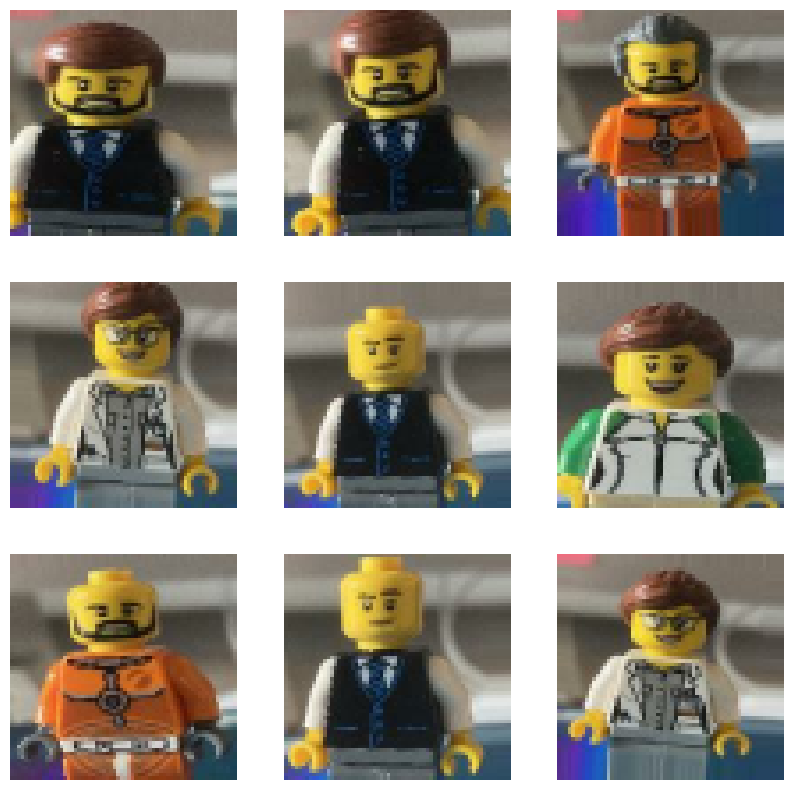

In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Rescaling(1./255) (encoder_input)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_30 (Conv2D)          (None, 32, 32, 200)          5600      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization_63 (Ba  (None, 32, 32, 200)          800       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 leaky_re_lu_63 (LeakyReLU)  (None, 32, 32, 200)          0         ['batch_normalization_63

In [ ]:
# Decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)

def inverse_rescaling(x):
        return x * 255

decoder_output = layers.Lambda(inverse_rescaling)(decoder_output)  # Применяем обратное масштабирование

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 20)]              0         
                                                                 
 dense_7 (Dense)             (None, 3200)              67200     
                                                                 
 batch_normalization_67 (Ba  (None, 3200)              12800     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_67 (LeakyReLU)  (None, 3200)              0         
                                                                 
 reshape_7 (Reshape)         (None, 4, 4, 200)         0         
                                                                 
 conv2d_transpose_35 (Conv2  (None, 8, 8, 200)         360200    
 DTranspose)                                               

In [ ]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [ ]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

In [ ]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [ ]:
vae.fit(
    train_data,
    epochs=EPOCHS)

Epoch 1/10
500/500 [==============================] - 36s 60ms/step - loss: 6166918.4386 - reconstruction_loss: 2263605.2500 - kl_loss: 754221.4375
Epoch 2/10
500/500 [==============================] - 29s 58ms/step - loss: 1468973.5968 - reconstruction_loss: 1411077.6250 - kl_loss: 192.9183
Epoch 3/10
500/500 [==============================] - 30s 59ms/step - loss: 1282004.7834 - reconstruction_loss: 1246190.5000 - kl_loss: 222.9551
Epoch 4/10
500/500 [==============================] - 29s 58ms/step - loss: 1161834.7690 - reconstruction_loss: 1144720.7500 - kl_loss: 249.7246
Epoch 5/10
500/500 [==============================] - 30s 59ms/step - loss: 1089671.7678 - reconstruction_loss: 1071928.2500 - kl_loss: 278.5421
Epoch 6/10
500/500 [==============================] - 29s 58ms/step - loss: 1034180.1713 - reconstruction_loss: 1020774.6250 - kl_loss: 304.2153
Epoch 7/10
500/500 [==============================] - 29s 58ms/step - loss: 984278.9310 - reconstruction_loss: 966948.3750 - kl

In [ ]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(
    list(train_data.take(batches_to_predict).get_single_element())
)

In [ ]:
import matplotlib.pyplot as plt


def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

1/1 [==============================] - 0s 419ms/step
Example real faces


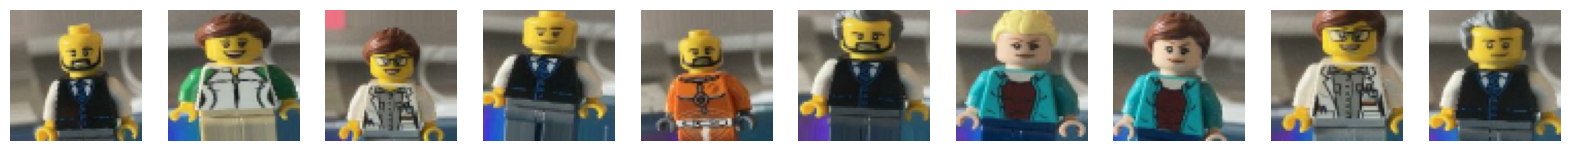

Reconstructions


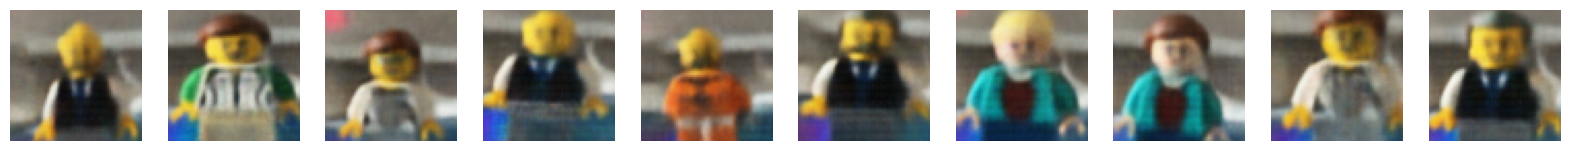

In [ ]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real faces")
display(example_images)
print("Reconstructions")
display(reconstructions)

In [ ]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [ ]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 179ms/step


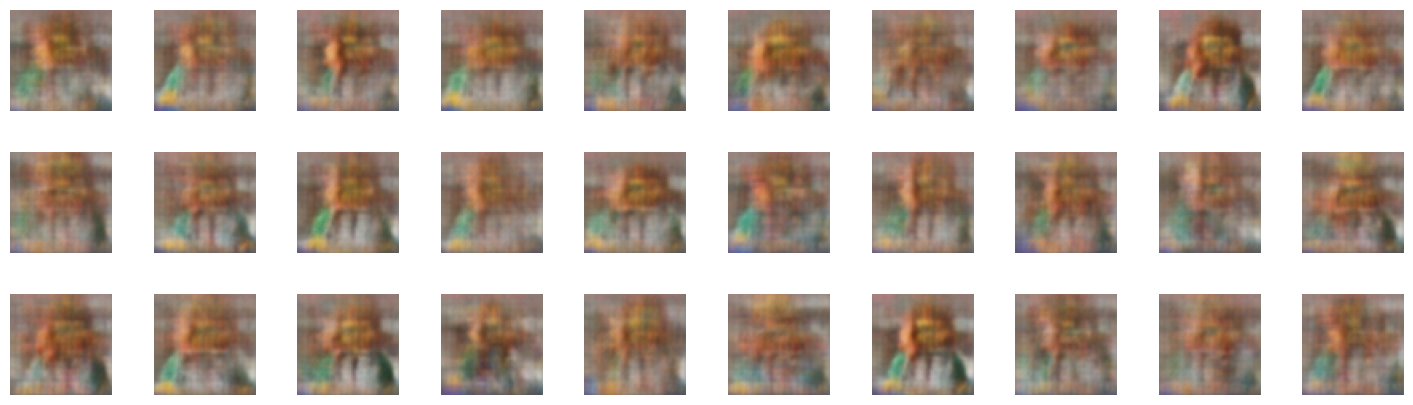

In [ ]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :].astype('uint8'))

In [ ]:
# Load the label dataset
attributes = pd.read_csv("/content/file_labels.csv")
print(attributes.columns)
attributes.head()
attributes.shape

Index(['file_name', 'bald', 'blond', 'brown', 'fair', 'ginger', 'grey'], dtype='object')


(12000, 7)

In [ ]:
attributes

,file_name,bald,blond,brown,fair,ginger,grey
0,0_label_bald.jpg,1.0,0.0,0.0,0.0,0.0,0.0
1,1_label_bald.jpg,1.0,0.0,0.0,0.0,0.0,0.0
2,2_label_bald.jpg,1.0,0.0,0.0,0.0,0.0,0.0
3,3_label_bald.jpg,1.0,0.0,0.0,0.0,0.0,0.0
4,4_label_bald.jpg,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
11995,11995_label_ginger.jpg,0.0,0.0,0.0,0.0,1.0,0.0
11996,11996_label_ginger.jpg,0.0,0.0,0.0,0.0,1.0,0.0
11997,11997_label_grey.jpg,0.0,0.0,0.0,0.0,0.0,1.0
11998,11998_label_grey.jpg,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Load the face data with label attached
LABEL = "blond"  # <- Set this label
labelled_test = utils.image_dataset_from_directory(
    "/content/train_data_lego",
    labels=attributes['bald'].tolist(),
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)


Found 12000 files belonging to 2 classes.
Using 2400 files for validation.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def get_vector_from_label(data, vae, embedding_dim, label):
    current_sum_POS = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_POS = 0
    current_mean_POS = np.zeros(shape=embedding_dim, dtype="float32")

    current_sum_NEG = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape=embedding_dim, dtype="float32")

    current_vector = np.zeros(shape=embedding_dim, dtype="float32")
    current_dist = 0

    print("label: " + label)
    print("images : POS move : NEG move :distance : 𝛥 distance")
    while current_n_POS < 10:
        batch = list(data.take(1).get_single_element())
        im = batch[0]
        attribute = batch[1]

        _, _, z = vae.encoder.predict(np.array(im), verbose=0)

        z_POS = z[attribute == 1]
        z_NEG = z[attribute == 0]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis=0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS - current_mean_POS)

        if len(z_NEG) > 0:
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis=0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG - current_mean_NEG)

        current_vector = new_mean_POS - new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist

        print(
            str(current_n_POS)
            + "    : "
            + str(np.round(movement_POS, 3))
            + "    : "
            + str(np.round(movement_NEG, 3))
            + "    : "
            + str(np.round(new_dist, 3))
            + "    : "
            + str(np.round(dist_change, 3))
        )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print("Found the " + label + " vector")
            break

    return current_vector


def add_vector_to_images(data, vae, feature_vec):
    n_to_show = 5
    factors = [-4, -3, -2, -1, 0, 1, 2, 3, 4]


    example_batch = list(data.take(1).get_single_element())
    example_images = example_batch[0]

    _, _, z_points = vae.encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):
        img = example_images[i]
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis("off")
        sub.imshow(img/255)

        counter += 1

        for factor in factors:
            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(
                np.array([changed_z_point]), verbose=0
            )[0]

            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis("off")
            sub.imshow(changed_image/255)

            counter += 1

    plt.show()


def morph_faces(data, vae):
    factors = np.arange(0, 1, 0.1)

    example_batch = list(data.take(1).get_single_element())[:2]
    example_images = example_batch[0]
    _, _, z_points = vae.encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img/255)

    counter += 1

    for factor in factors:
        changed_z_point = z_points[0] * (1 - factor) + z_points[1] * factor
        changed_image = vae.decoder.predict(
            np.array([changed_z_point]), verbose=0
        )[0]
        sub = fig.add_subplot(1, len(factors) + 2, counter)
        sub.axis("off")
        sub.imshow(changed_image/255)

        counter += 1

    img = example_images[1]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img/255)

    plt.show()

In [ ]:
# Find the attribute vector
attribute_vec = get_vector_from_label(labelled_test, vae, Z_DIM, LABEL)

label: blond
images : POS move : NEG move :distance : 𝛥 distance
4    : 17.998    : 8.699    : 20.378    : 20.378
7    : 9.784    : 4.007    : 13.629    : -6.749
12    : 6.64    : 2.352    : 8.87    : -4.759


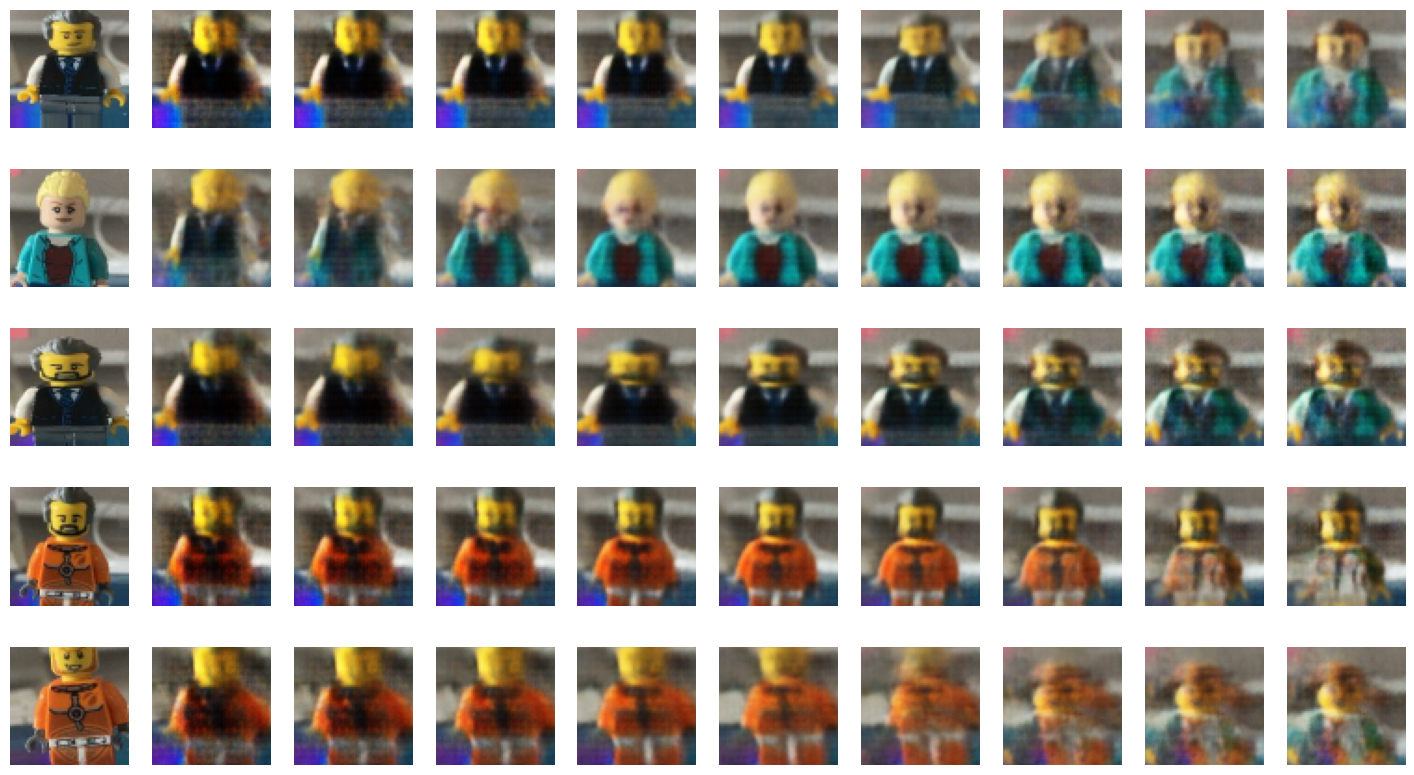

In [ ]:
# Add vector to images
add_vector_to_images(labelled_test, vae, attribute_vec)

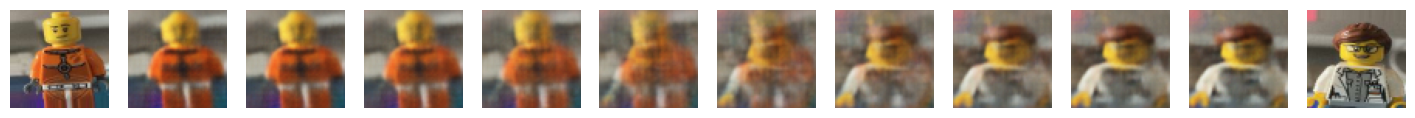

In [ ]:
morph_faces(labelled_test, vae)

**Освоение функций get_vector_from_label**

In [ ]:
def get_vector_from_label(data, vae, embedding_dim, label):
    current_sum_POS = np.zeros(shape=embedding_dim, dtype="float32")
    print(current_sum_POS)
    current_n_POS = 0
    current_mean_POS = np.zeros(shape=embedding_dim, dtype="float32")
    print(current_mean_POS)

    current_sum_NEG = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape=embedding_dim, dtype="float32")

    current_vector = np.zeros(shape=embedding_dim, dtype="float32")
    current_dist = 0

    #print("label: " + label)
    #print("images : POS move : NEG move :distance : 𝛥 distance")
    while current_n_POS < 2:
      print(current_n_POS)
        batch = list(data.take(1).get_single_element())
        im = batch[0]
        attribute = batch[1]

        _, _, z = vae.encoder.predict(np.array(im), verbose=0)

        z_POS = z[attribute == 1]
        z_NEG = z[attribute == 0]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis=0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS - current_mean_POS)

        if len(z_NEG) > 0:
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis=0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG - current_mean_NEG)

        current_vector = new_mean_POS - new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist

        print(
            str(current_n_POS)
            + "    : "
            + str(np.round(movement_POS, 3))
            + "    : "
            + str(np.round(movement_NEG, 3))
            + "    : "
            + str(np.round(new_dist, 3))
            + "    : "
            + str(np.round(dist_change, 3))
        )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print("Found the " + label + " vector")
            break

    return current_vector

IndentationError: unexpected indent (<ipython-input-225-744b4c2488f0>, line 19)

In [ ]:
# Find the attribute vector
attribute_vec = get_vector_from_label(labelled_test, vae, 20, LABEL)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.], shape=(24,), dtype=float32)
4    : 3.588    : 1.059    : 3.754    : 3.754


In [ ]:
test=list(labelled_test.take(1).get_single_element())
len(test[0])

24

In [ ]:
a, b, z = vae.encoder.predict(np.array(test[0]), verbose=0)

In [ ]:
z_POS
z_test=np.array([[2,1],[1,1],[1,1]])

In [ ]:
np.sum(z_test, axis=0)

array([4, 3])